<a href="https://colab.research.google.com/github/Hamza1122/Pose_Estimation_Yolo_Points/blob/main/FYP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [2]:
# !unzip imagesrc.zip

Archive:  imagesrc.zip
   creating: imagesrc/ahmed/
  inflating: imagesrc/ahmed/frame100.jpg  
  inflating: imagesrc/ahmed/frame101.jpg  
  inflating: imagesrc/ahmed/frame102.jpg  
  inflating: imagesrc/ahmed/frame103.jpg  
  inflating: imagesrc/ahmed/frame104.jpg  
  inflating: imagesrc/ahmed/frame105.jpg  
  inflating: imagesrc/ahmed/frame106.jpg  
  inflating: imagesrc/ahmed/frame107.jpg  
  inflating: imagesrc/ahmed/frame108.jpg  
  inflating: imagesrc/ahmed/frame109.jpg  
  inflating: imagesrc/ahmed/frame110.jpg  
  inflating: imagesrc/ahmed/frame111.jpg  
  inflating: imagesrc/ahmed/frame112.jpg  
  inflating: imagesrc/ahmed/frame113.jpg  
  inflating: imagesrc/ahmed/frame114.jpg  
  inflating: imagesrc/ahmed/frame115.jpg  
  inflating: imagesrc/ahmed/frame116.jpg  
  inflating: imagesrc/ahmed/frame117.jpg  
  inflating: imagesrc/ahmed/frame118.jpg  
  inflating: imagesrc/ahmed/frame119.jpg  
  inflating: imagesrc/ahmed/frame120.jpg  
  inflating: imagesrc/ahmed/frame121.jpg  
  

**Object Detection Angles**

In [3]:
angles = pd.read_csv('angles.csv')
angles.columns=['images','angles','distance']
angles.head(10)

,images,angles,distance
0,img\Ahmed100.jpg,168.183585,0.677831
1,img\Ahmed101.jpg,167.413389,0.680949
2,img\Ahmed102.jpg,167.661262,0.679942
3,img\Ahmed103.jpg,166.819833,0.683372
4,img\Ahmed104.jpg,166.314019,0.685450
5,img\Ahmed105.jpg,165.902660,0.687150
6,img\Ahmed106.jpg,166.015987,0.686681
7,img\Ahmed107.jpg,165.941673,0.686988
8,img\Ahmed108.jpg,168.345179,0.677180
9,img\Ahmed109.jpg,168.308502,0.677328


In [4]:
angles = angles.fillna(0)
angles.columns

Index(['images', 'angles', 'distance'], dtype='object')

In [5]:
angles.isnull().sum()
angles.shape

(1007, 3)

**Pose Estimation Points**

In [6]:
df=pd.read_csv('pose.csv')

df.columns=['Image','Class','Neck_to_RShoulder','Neck_to_LShoulder','RShoulder_to_RElbow',
                                  'RElbow_to_RWrist','LShoulder_to_LElbow','LElbow_to_LWrist','Neck_to_RHip',
                                  'RHip_to_RKnee','RKnee_to_RAnkle','Neck_to_LHip','LHip_to_LKnee',
                                  'LKnee_to_LAnkle','Neck_to_Nose','Nose_to_REye','REye_to_REar',
                                  'Nose_to_LEye','LEye_to_LEar']
df.head(10)

,Image,Class,Neck_to_RShoulder,Neck_to_LShoulder,RShoulder_to_RElbow,RElbow_to_RWrist,LShoulder_to_LElbow,LElbow_to_LWrist,Neck_to_RHip,RHip_to_RKnee,RKnee_to_RAnkle,Neck_to_LHip,LHip_to_LKnee,LKnee_to_LAnkle,Neck_to_Nose,Nose_to_REye,REye_to_REar,Nose_to_LEye,LEye_to_LEar
0,img\Ahmed100.jpg,Ahmed,15,15,15,14,27,16,28,28,28,27,28,28,20,15,14,14,31
1,img\Ahmed101.jpg,Ahmed,15,7,15,14,13,16,28,28,28,27,28,42,20,20,29,14,31
2,img\Ahmed102.jpg,Ahmed,15,7,15,14,13,16,28,28,28,41,15,42,20,15,14,26,28
3,img\Ahmed103.jpg,Ahmed,15,7,15,14,13,16,28,28,28,41,15,42,15,7,14,22,15
4,img\Ahmed104.jpg,Ahmed,15,7,15,14,13,29,41,28,29,41,14,42,15,7,14,0,20
5,img\Ahmed105.jpg,Ahmed,15,7,15,14,13,29,41,28,29,41,28,28,8,15,28,20,7
6,img\Ahmed106.jpg,Ahmed,15,7,15,14,28,14,41,28,29,41,28,28,8,8,16,20,7
7,img\Ahmed107.jpg,Ahmed,8,7,14,16,15,28,41,28,29,41,28,28,8,8,16,20,7
8,img\Ahmed108.jpg,Ahmed,8,7,14,29,28,14,41,28,29,41,28,28,8,8,16,20,7
9,img\Ahmed109.jpg,Ahmed,8,7,14,29,28,14,41,28,28,41,28,28,8,8,16,7,20


In [7]:
df.shape

(1011, 19)

In [8]:
df=pd.merge(df,angles, how='left', left_on='Image', right_on='images')   #merge both datasets and duplicates will be removed automatically

In [9]:
df=df.fillna(0)

In [10]:
df=df.drop(['Image','Class','images'],axis=1)
df.head(10)

,Neck_to_RShoulder,Neck_to_LShoulder,RShoulder_to_RElbow,RElbow_to_RWrist,LShoulder_to_LElbow,LElbow_to_LWrist,Neck_to_RHip,RHip_to_RKnee,RKnee_to_RAnkle,Neck_to_LHip,LHip_to_LKnee,LKnee_to_LAnkle,Neck_to_Nose,Nose_to_REye,REye_to_REar,Nose_to_LEye,LEye_to_LEar,angles,distance
0,15,15,15,14,27,16,28,28,28,27,28,28,20,15,14,14,31,168.183585,0.677831
1,15,7,15,14,13,16,28,28,28,27,28,42,20,20,29,14,31,167.413389,0.680949
2,15,7,15,14,13,16,28,28,28,41,15,42,20,15,14,26,28,167.661262,0.679942
3,15,7,15,14,13,16,28,28,28,41,15,42,15,7,14,22,15,166.819833,0.683372
4,15,7,15,14,13,29,41,28,29,41,14,42,15,7,14,0,20,166.314019,0.685450
5,15,7,15,14,13,29,41,28,29,41,28,28,8,15,28,20,7,165.902660,0.687150
6,15,7,15,14,28,14,41,28,29,41,28,28,8,8,16,20,7,166.015987,0.686681
7,8,7,14,16,15,28,41,28,29,41,28,28,8,8,16,20,7,165.941673,0.686988
8,8,7,14,29,28,14,41,28,29,41,28,28,8,8,16,20,7,168.345179,0.677180
9,8,7,14,29,28,14,41,28,28,41,28,28,8,8,16,7,20,168.308502,0.677328


In [11]:
df.shape

(1011, 19)

In [12]:
df.corr()

,Neck_to_RShoulder,Neck_to_LShoulder,RShoulder_to_RElbow,RElbow_to_RWrist,LShoulder_to_LElbow,LElbow_to_LWrist,Neck_to_RHip,RHip_to_RKnee,RKnee_to_RAnkle,Neck_to_LHip,LHip_to_LKnee,LKnee_to_LAnkle,Neck_to_Nose,Nose_to_REye,REye_to_REar,Nose_to_LEye,LEye_to_LEar,angles,distance
Neck_to_RShoulder,1.000000,0.704698,0.748809,0.655798,0.718135,0.668618,0.820149,0.609222,0.469054,0.812124,0.712578,0.487592,0.645184,0.049901,0.019579,0.054071,0.073183,-0.728348,-0.118880
Neck_to_LShoulder,0.704698,1.000000,0.784294,0.655951,0.720034,0.703866,0.833379,0.650778,0.506152,0.842441,0.719607,0.498489,0.580598,0.046333,-0.000697,0.021882,0.018777,-0.762601,-0.097433
RShoulder_to_RElbow,0.748809,0.784294,1.000000,0.619827,0.792198,0.690872,0.870272,0.697136,0.576002,0.863970,0.652321,0.472878,0.584790,0.023125,-0.011545,0.002890,-0.010667,-0.743553,-0.178651
RElbow_to_RWrist,0.655798,0.655951,0.619827,1.000000,0.636969,0.673304,0.720066,0.576364,0.445020,0.710950,0.620423,0.430418,0.514790,-0.007039,-0.034977,-0.054904,-0.008986,-0.661277,-0.162857
LShoulder_to_LElbow,0.718135,0.720034,0.792198,0.636969,1.000000,0.557699,0.820818,0.614936,0.432507,0.815785,0.660963,0.373534,0.506211,0.025573,0.000441,0.021060,0.017072,-0.705465,-0.121400
LElbow_to_LWrist,0.668618,0.703866,0.690872,0.673304,0.557699,1.000000,0.759206,0.555296,0.430478,0.754727,0.662382,0.410923,0.547936,0.028066,-0.032420,-0.032201,-0.043753,-0.689234,-0.123271
Neck_to_RHip,0.820149,0.833379,0.870272,0.720066,0.820818,0.759206,1.000000,0.688303,0.538360,0.978035,0.763025,0.516229,0.617889,0.018399,-0.019233,-0.002271,-0.002697,-0.851250,-0.144610
RHip_to_RKnee,0.609222,0.650778,0.697136,0.576364,0.614936,0.555296,0.688303,1.000000,0.657095,0.696177,0.633578,0.367863,0.478972,0.008476,-0.015789,-0.024812,-0.020048,-0.647569,-0.090486
RKnee_to_RAnkle,0.469054,0.506152,0.576002,0.445020,0.432507,0.430478,0.538360,0.657095,1.000000,0.538413,0.309171,0.476536,0.371992,0.029635,-0.002779,0.009318,0.001363,-0.486539,-0.109683
Neck_to_LHip,0.812124,0.842441,0.863970,0.710950,0.815785,0.754727,0.978035,0.696177,0.538413,1.000000,0.728746,0.521473,0.610425,0.012793,-0.023357,-0.001943,-0.002805,-0.853093,-0.137577


In [13]:
IMG_SIZE = 50
data = r"/content/imagesrc/"
cate = ["ahmed","amman","hannan","sajid","sami","shumail","steve","wajid"]


In [14]:
training_data = []
temp_array=[]

def create_training_data():
    for category in cate:
        
        path = os.path.join(data,category)
        class_num = cate.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                temp_array.append(img_array)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

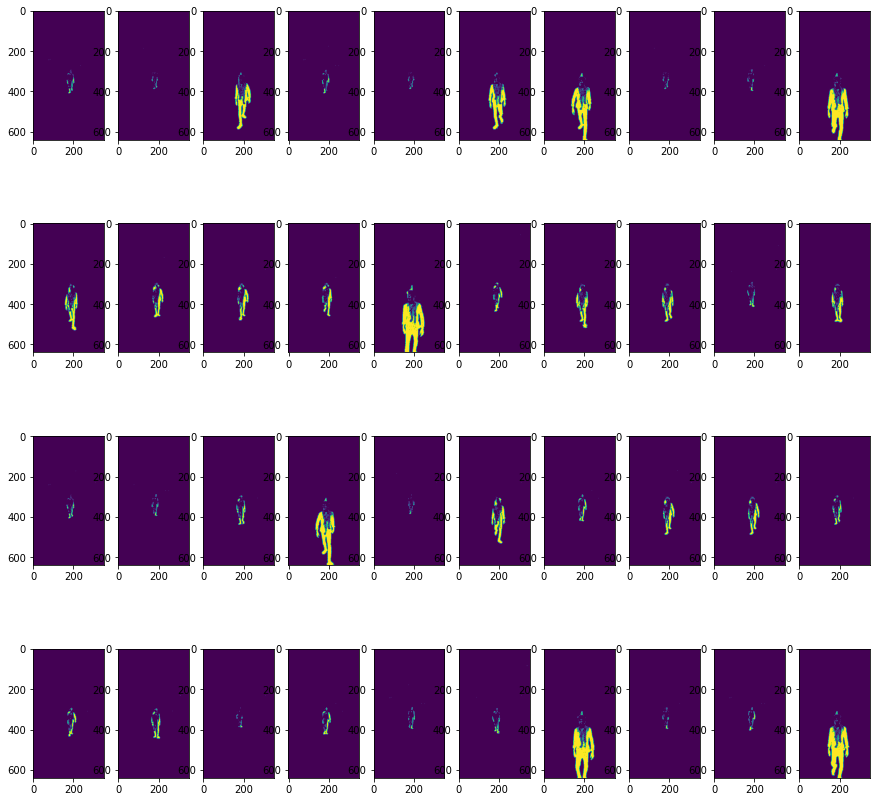

In [15]:
w=12
h=12
fig=plt.figure(figsize=(15,15))
columns =10
rows =4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp_array[i])
plt.show()

In [16]:
random.shuffle(training_data)
X = [] 
y = [] 

for features, label in training_data:
	X.append(features)
	y.append(label)

In [17]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X.shape

(1011, 50, 50, 1)

In [18]:
y=np.array(y)
len(y)

1011

In [19]:
from keras.utils import np_utils

X= X.astype('float32')
X/= 255
n_classes = 8

In [20]:
Y_train = np_utils.to_categorical(y, n_classes)

In [21]:
from keras.models import Sequential
from keras.models import model_from_json

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten



In [22]:
min_max_scaler = preprocessing.MinMaxScaler()   #normalizing the data
df = min_max_scaler.fit_transform(df)

**Multi-Layer Perceptron (MLP)**

In [23]:
#https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# Multilayer Perceptron (MLP)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
visible = Input(shape=(19,))    #19 size of the columns
hidden1 = Dense(10, activation='relu')(visible)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)
output = Dense(8, activation='softmax')(hidden3)   #5 number of classess
model_mlp = Model(inputs=visible, outputs=output)


**MLP + CNN**

In [24]:
# Convolutional Neural Network
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

visible = Input(shape=(50,50,1))

conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)

conv2 = Conv2D(16, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)

flat = Flatten()(pool2)
hidden1 = Dense(10, activation='relu')(flat)
output = Dense(8, activation='softmax')(hidden1)

model_cnn = Model(inputs=visible, outputs=output)


In [25]:
from keras.layers import concatenate
combinedInput = concatenate([model_mlp.output,model_cnn.output])

In [26]:
x = Dense(4, activation="relu")(combinedInput)
x = Dense(8, activation="softmax")(x)

In [27]:
model = Model(inputs=[model_mlp.input,model_cnn.input], outputs=x)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 19)]         0                                            
____________________________________________________________________________________________

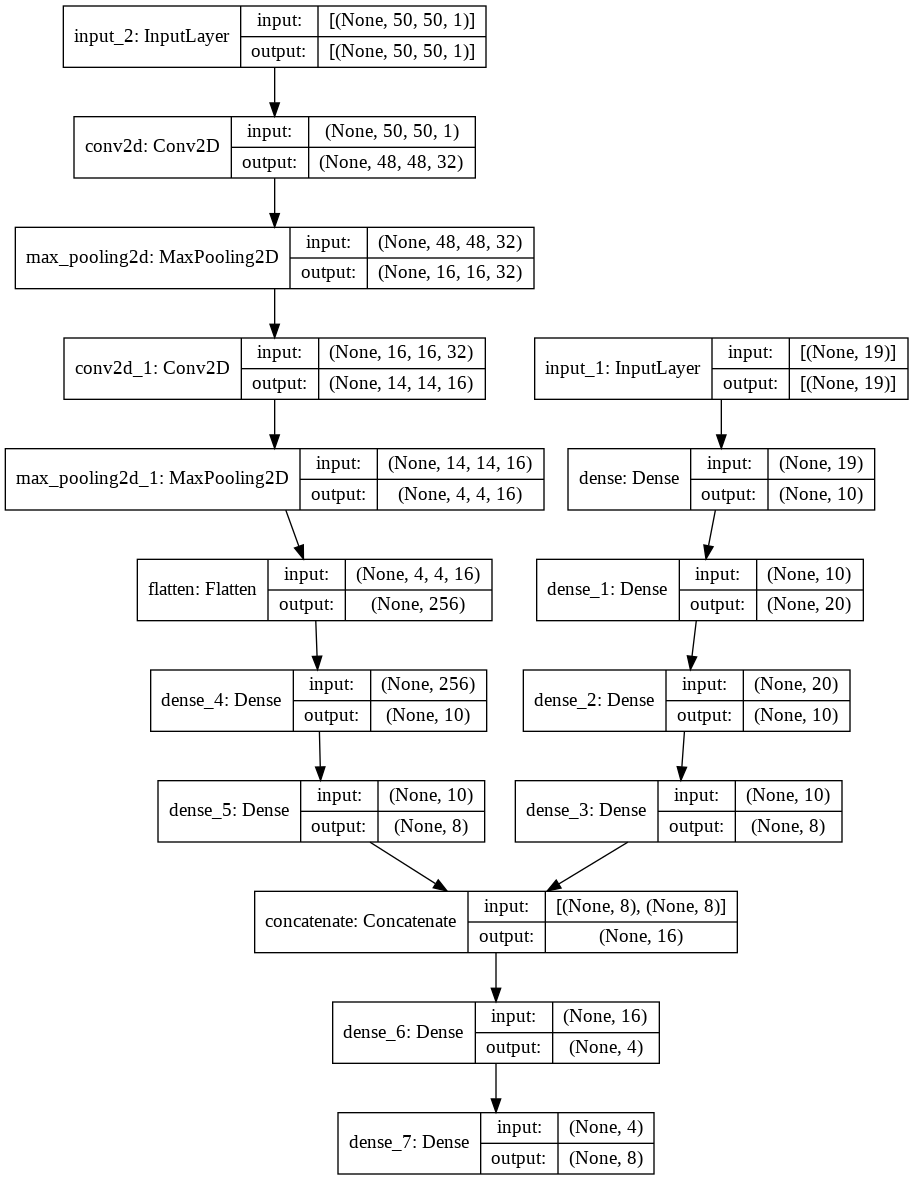

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate


opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', loss_weights=[1.0,0.2],metrics=['acc'])

In [30]:
n_classes = 8

Y_train = np_utils.to_categorical(y, n_classes)

print("Shape after one-hot encoding: ", Y_train.shape)


Shape after one-hot encoding:  (1011, 8)


In [31]:
X_train,X_val_numeric,X_images,X_val_Images,y_train,y_val =  train_test_split(df,X,Y_train, test_size=0.33, random_state=42)

In [32]:
history=model.fit(
	x=[X_train,X_images], y=y_train,validation_data=([X_val_numeric,X_val_Images],y_val),
	epochs=500, batch_size=120)

Epoch 1/500
6/6 [==============================] - 3s 295ms/step - loss: 2.0774 - acc: 0.1399 - val_loss: 2.0744 - val_acc: 0.1875
Epoch 2/500
6/6 [==============================] - 1s 154ms/step - loss: 2.0698 - acc: 0.1880 - val_loss: 2.0693 - val_acc: 0.1875
Epoch 3/500
6/6 [==============================] - 1s 158ms/step - loss: 2.0562 - acc: 0.1854 - val_loss: 2.0568 - val_acc: 0.1875
Epoch 4/500
6/6 [==============================] - 1s 155ms/step - loss: 2.0475 - acc: 0.1543 - val_loss: 2.0486 - val_acc: 0.1875
Epoch 5/500
6/6 [==============================] - 1s 150ms/step - loss: 2.0311 - acc: 0.1789 - val_loss: 2.0404 - val_acc: 0.1875
Epoch 6/500
6/6 [==============================] - 1s 150ms/step - loss: 2.0317 - acc: 0.1612 - val_loss: 2.0316 - val_acc: 0.1875
Epoch 7/500
6/6 [==============================] - 1s 155ms/step - loss: 2.0198 - acc: 0.1640 - val_loss: 2.0239 - val_acc: 0.1875
Epoch 8/500
6/6 [==============================] - 1s 154ms/step - loss: 2.0059 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


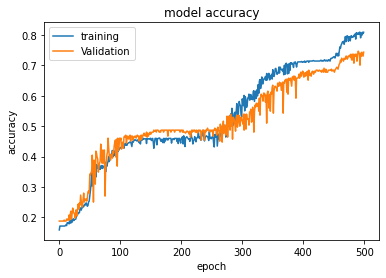

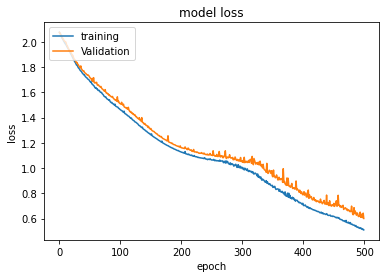

In [34]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'], loc='upper left')
plt.show()

[[8.1125945e-06 3.1066838e-01 1.7822216e-01 ... 8.0820806e-05
  1.5035066e-01 3.5782367e-01]
 [8.0865257e-06 3.1068015e-01 1.7831333e-01 ... 8.0501275e-05
  1.5014254e-01 3.5793397e-01]
 [8.3515756e-03 1.6496520e-08 1.7443615e-08 ... 1.0783017e-05
  4.1941684e-07 5.9909615e-09]
 ...
 [9.6975738e-01 4.9830353e-09 1.7002952e-09 ... 9.9063218e-03
  1.4198948e-06 1.0397742e-09]
 [6.8251272e-03 9.5964747e-09 1.0286564e-08 ... 7.4383993e-06
  2.5610166e-07 3.4408782e-09]
 [6.5289563e-03 1.7333542e-10 1.5942128e-12 ... 9.9347091e-01
  4.8264841e-09 1.9062998e-11]]


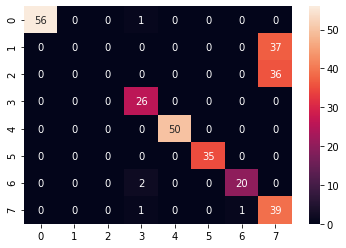

In [35]:
y_new = model.predict(([X_val_numeric,X_val_Images]))
print(y_new)

results = np.argmax(y_new,axis=1)
matrix = metrics.confusion_matrix(y_val.argmax(axis=1), y_new.argmax(axis=1))


sns.heatmap(matrix,annot=True)

In [ ]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:


json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)




loaded_model.load_weights("model.h5")
print("Loaded model from disk")
score = loaded_model.predict(([X_val_numeric,X_val_Images]), verbose=0)
results = np.argmax(score,axis=1)
print(results)

Loaded model from disk
[8 6 7 4 4 3 7 0 7 8 3 2 8 4 5 4 8 0 1 2 0 5 5 8 1 4 0 2 8 7 5 4 4 5 4 7 7
 4 0 4 4 1 8 4 0 1 7 1 8 8 0 8 2 0 7 8 1 7 0 0 7 3 0 1 0 5 1 5 0 5 6 0 0 6
 6 1 0 7 5 5 7 4 1 5 6 5 3 0 4 8 4 8 7 4 1 3 0 0 4 7 5 2 4 4 4 1 5 0 7 7 8
 4 5 0 5 5 3 4 7 8 0 1 0 8 1 1 3 0 5 0 0 4 0 3 3 0 0 0 1 0 2 5 5 0 0 4 1 7
 8 4 8 7 0 1 6 1 0 5 5 3 4 0 7 0 0 0 3 7 5 4 8 7 6 7 1 4 5 7 7 5 8 0 5 0 2
 7 0 3 4 6 5 3 7 3 5 0 3 0 1 8 8 8 6 3 8 6 8 3 0 4 8 4 0 7 2 1 8 6 0 2 7 0
 1 4 0 3 6 1 7 8 6 0 1 1 4 3 7 3 8 1 3 4 8 0 3 7 0 5 7 1 1 5 6 7 7 1 3 0 0
 7 4 3 7 6 3 1 6 8 6 7 3 0 8 2 6 0 7 1 0 5 2 4 4 2 1 0 3 6 5 0 7 4 6 8 4 5
 4 2 1 4 3 2 0 4 2 2 0 3 4 8 3 0 4 5 2 8 5 3 0 1 7 2 0 5 0 1 3 0 8 2 1 0 1
 4 5 5 8 0 6 6 4 5 6 0 0 0 0 4 6 4 0 1 7 1 4 4 1]


**Convolutional Neural Network (CNN)**

In [ ]:
image_size = X_images.shape[1]
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 5
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
# image to vector before connecting to dense layer
y = Flatten()(y)
# dropout regularization
#y = Dropout(dropout)(y)
outputs = Dense(9, activation='softmax')(y)

# build the model by supplying inputs/outputs
model_cnn = Model(inputs=inputs, outputs=outputs)
# network model in text
model_cnn.summary()

# classifier loss, Adam optimizer, classifier accuracy
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
history=model_cnn.fit(X_images,
          y_train,
          epochs=300,
          batch_size=110,validation_data=(X_val_Images,y_val)
          )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 64)          102464    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0   

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


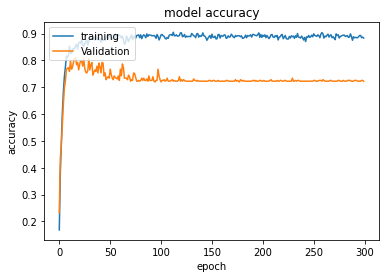

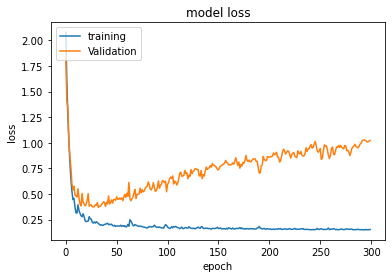

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
!unzip new_test.zip

unzip:  cannot find or open new_test.zip, new_test.zip.zip or new_test.zip.ZIP.


**Testing Data**

In [ ]:
category_name = []
testing_data = []
temp_array=[]

file_path = '/content/imagesrc/imagesrc'
files = os.listdir(file_path)

for f in files:
  category_name.append(f)
print(category_name)


In [ ]:
data=r"/content/new_test/"

category_path = '/content/new_test'
person_name = os.listdir(category_path)
person_name = ''.join([str(elem) for elem in person_name])
person_name

In [ ]:
cate=[person_name]

def create_testing_data():
    for category in cate:
        path = os.path.join(data,category)
        class_num = category_name.index(person_name)
        
        for img in os.listdir(path):
            
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                temp_array.append(img_array)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])
            
            except Exception as e:
                pass
create_testing_data()

In [ ]:
X_test=[]
y_test=[]


df_angle = pd.read_csv('new_angles.csv',names=['images','angles','distance'])
df_angle = df_angle.fillna(0)


df_test=pd.read_csv('new_pose.csv')


df_angle['path'] = df_test['Image']
df=pd.merge(df_test,df_angle, how='left', left_on='Image', right_on='path')   #merge both datasets and duplicates will be removed automatically
df=df.fillna(0)

In [ ]:
df=df.drop(['Image','Class','images','path'],axis=1)

for features, label in testing_data:
  X_test.append(features)
  y_test.append(label)

y_test=np.array(y_test)
len(y_test)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()   #normalizing the data
df = min_max_scaler.fit_transform(df)

In [ ]:
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
X_test=X_test.astype('float')
X_test=X_test/ 255 

y_test = np_utils.to_categorical(y_test)


In [ ]:
y_new = model.predict(([df,X_test]))
print(y_new)

In [ ]:
results = np.argmax(y_new,axis=1)
results

# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_new.argmax(axis=1))


**Algorithm Comparison**

|Algorithm|Accuracy|Validation_Accuracy| No.of Layers|Epochs| Filter Size|Kernel Size|Pool Size|
|---------|--------|-------------------|-------|----|---|----|----
|CNN + MLP|0.57|0.53|-------|500 | 64| 3x3| 3x3|
|CNN + MLP|0.86|0.75|-------|1000| 64| 3x3| 3x3|
|CNN + MLP|0.83|0.73|-------|500 | 64| 5x5| 5x5|
|CNN + MLP|0.90|0.70|-------|1000| 64| 5x5| 5x5|
|CNN      |0.87|0.76|-------|100| 64| 3x3| 3x3|
|CNN      |0.88|0.76|-------|300| 64| 3x3| 3x3|




   
